# 2-D  (x-z) Lagrangian particle transport.  

Hint: You might be able to re-use parts of the code from your 1-D Lagrangian homework.

## A) Mean Wind

Implement the Hysplit mean-wind advection scheme in your own code, for just the U wind.

1) First:
       Implement the following artificial mean wind environment where the mean U ind varies in x and z,
       within which you may test your 1-D (x-direction) mean advection by the U component of wind. 
       Assume V = 0 , W = 0.  And neglect turbulence in the x-direction (i.e., u' = 0).
      I do this by assuming U obeys the log wind profile with z, and that u* varies with x.

Hint: create functions for the following equations:
Use `u*` as a function of `x`:  `ustar = ustar0 + ustar1*( (x/L) * (1. - (x/L)) )`
Use `U` as a function of `z` and `u*`:  `U = (ustar/0.4) * log( (z+zo)/zo )`


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Given:
ustar0 = 0.05      # first u* constant (m/s)
ustar1 = 1.0       # second u* constant (m/s)
zo = 0.02          # roughness length (m)
L = 50000.         # horizontal domain (m).   0 ≤ L ≤ 50 km
zi = 1000.         # your veritical domain is 0 ≤ z ≤ zi

# general
g_by_tv = 0.0333    # g/Tv approx constant  (m s^-2 K^-1)
rho_cp = 1231.      # air density x specific heat at const press, is constant. (W/m2)/(K m/s)

# unstable pbl
Hsfc = 50.                # surface heat flux (W/m2)
FHsfc = Hsfc / rho_cp     # kinematic heat flux (K m/s) at the surface
wstar = (g_by_tv * FHsfc * zi) ** (1/3)          # Deardorff convective velocity
tlvert = 200.             # lagrangian time scale for vertical motions for unstable pbl (s)

dt = 60.                  # timestep increment (s) for tracking any one particle

# plume info
nparticles = 1            # number of particles  (emitted as a single burst at t = 0)
zs = 100.                 # source emission height (m) for all particle

In [3]:
def get_wind(x, z):
    """
    outputs the mean horizontal wind at a position x, z according to
    hysplit's mean wind scheme
    """
    ustar = ustar0 + ustar1 * ((x / L) * (1.0 - (x / L)))
    U = (ustar / 0.4) * np.log((z + zo) / zo)
    return [U, 0]

2) To see what you produced, calculate U(x,z) for fairly high resolution in x, and z,
and then plot it as a contour plot. 

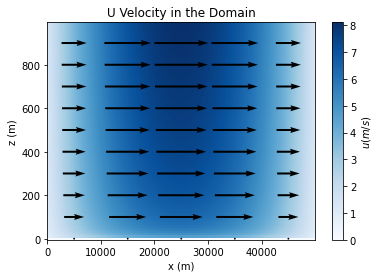

In [4]:
h_res = 10  # horizontal resolution (m)
v_res = 10  # vertical resolution (m)

# create vectors x and z
x = np.arange(0, L, h_res)
z = np.arange(0, zi, v_res)

# calculate U
grid = np.meshgrid(x, z)
U = get_wind(grid[0], grid[1])

# plot it
wind = plt.pcolormesh(x, z, U[0], shading="auto", cmap="Blues")
plt.colorbar(wind, label="$u (m/s)$")
plt.quiver(
    x[500::1000], z[::10], U[0][::10, 500::1000], np.zeros(50), pivot="middle", scale=40
)
plt.title("U Velocity in the Domain")
plt.xlabel("x (m)")
plt.ylabel("z (m)");

3) Implement the Hypslit mean advection scheme, and test it for a particle released
  at (x, z) = (0, 100. m).   Namely the source height is zs = 100.
  This scheme is given by eq. (1) in the Stein et al paper (2015) in BAMS.  (See our course web page.)
  Namely, neglecting vertical turbulence for now, calculate the postion of the one particle at each
  time step (pick reasonable time steps) as it advects to the East, and plot the positions of the
  particle within the (x, z) domain.

$$
P_{mean}(t + \Delta t) = P_{mean}(t) + \frac{1}{2}\left[V(P_{mean},t) + V((P_{mean}(t) + [V(P_{mean},t)\Delta t, t + \Delta t)\right]\Delta t\tag{BAMS 1}
$$

In [5]:
def step_forward_U(pmt, dt=dt):
    """
    Steps a lagrangian particle forward one timestep, given
    mean windspeed function U(x,z) as per BAMS (1)
    """
    pmt_next = pmt + 0.5 * dt * (
        np.array(get_wind(pmt[0], pmt[1])) + np.array(get_wind(pmt[0], pmt[1]))
    )
    return pmt_next

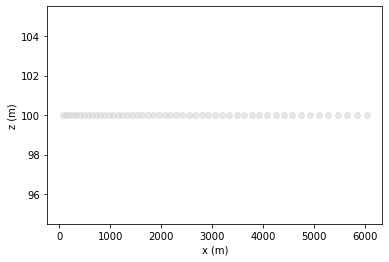

In [26]:
pmt = np.array([0, 100])  # x, z (m) initial position

# create initial arrays
x = np.array([])
y = np.array([])

# take 50 timesteps forward
for i in range(50):
    pmt = step_forward_U(pmt)
    x = np.append(x, pmt[0])
    y = np.append(y, pmt[1])
    
# plot the result  
alpha=0.5
fig, ax = plt.subplots()
ax.scatter(x, y, color="lightgrey", alpha=alpha)
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)");    

## B) Vertical Turbulence

Add the vertical turbulent dispersion code from your previous 1-D Lagrangian homework. 
Use your code that included reflection from z=0 and z=zi, and which prevented accumulation of
particles near the top and bottom edges.


1) Plot the track of this 1 particle in your (x, z) domain, until it exits the domain.
Use light gray colour for all the plotted points.

In [9]:
# get all the definitions and functions from ast4
%run "../ast4/ast4.ipynb"

In [10]:
def step_forward_wprime(pmt, wp, dt=dt):
    """
    Steps a lagrangian particle forwards, given the 
    turbulent vertical field in BAMS supplement ES15
    """
    # calculate turbulence intensity at current height
    sigma_w = get_sigma_w2(pmt[1]) ** 0.5
    dsigdz = get_dsigdz(pmt[1])
    
    # random number representing turb intensity at a point
    lmda = np.random.default_rng().normal(0, 1)
    
    # w' equation
    wp = (wp * R) \
         + sigma_w * lmda * (1 - R ** 2) ** 0.5 \
         + (sigma_w * tlvert * (1 - R) * dsigdz)
    
    # get the old height and calculate the new one
    z_new = pmt[1] + wp * dt
    
    # reflect particles off the floor and ceiling
    if (z_new < 0) or (z_new > zi):
        z_new = pmt[1] - wp * dt
    
    return np.array([pmt[0], z_new])

In [18]:
def do_LPT(): 
    """
    Execute a a lagrangian particle trajectory run
    """
    x = np.array([])
    y = np.array([])

    pmt = np.array([0, 100])  # x, z (m) initial position
    wp = 0 # initial vertical velocity
    while pmt[0] < L:
        pmt = step_forward_U(pmt)
        pmt = step_forward_wprime(pmt, wp)
        x = np.append(x, pmt[0])
        y = np.append(y, pmt[1])
    
    # pad the end of the array so all are length 1000
    extra_nans = np.full(1000 - len(x), np.nan)
    x = np.append(x, extra_nans)
    y = np.append(y, extra_nans)
    return x, y

In [19]:
x, y = do_LPT()

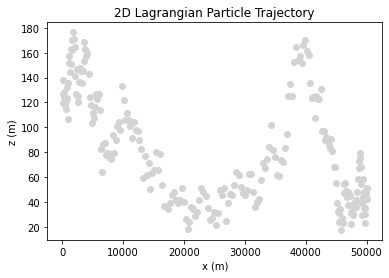

In [21]:
# plot result
fig, ax = plt.subplots()
ax.scatter(x, y, color="lightgrey", alpha=alpha)
ax.set_title("2D Lagrangian Particle Trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)");

2) Re-do (1), but with the following special colour scheme.  First 10 positions use gray.
Next 2 positions, use red.  Next 10 positions gray.  Next 2 positions, use orange.
Next 10 gray.  Next 2 gold.  next 10 gray.  next 2 green.  next 10 gray.  next 2 blue.
Next 10 gray.  Next 2 violet.
Repeat the colour sequence (grays and rainbow colours)
as needed to cover the whole track of the particle until it exits the domain.

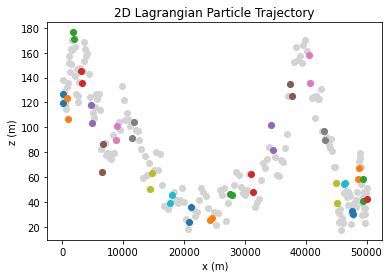

In [22]:
# plot result
fig, ax = plt.subplots()
ax.scatter(x, y, color="lightgrey", alpha=alpha)
ax.set_title("2D Lagrangian Particle Trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")

for i in range(len(x)):
    if i % 10 == 0:
        ax.scatter([x[i], x[i+1]], [y[i], y[i+1]])

## C) Particles and concentrations.

1) Re-do B(2), but for 2 particles released simultaneously (at t = 0, z = zs).  Plot their tracks in 
the (x,z) domain. Also, use the identical colour scheme from B(2) for each particle, except plot two 
points as BLACK when the first of these 2 points is t = 120 time steps from their release time. 



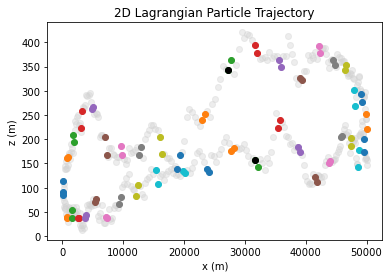

In [29]:
fig, ax = plt.subplots()
ax.set_title("2D Lagrangian Particle Trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
for j in range(2):
    x, y = do_LPT()
    ax.scatter(x, y, color="lightgrey", alpha=0.4)
    for i in range(len(x)):
        if i % 10 == 0:
            ax.scatter([x[i], x[i+1]], [y[i], y[i+1]])
        if i == 120:
            ax.scatter(x[i], y[i], color="k")

2) Re-do C(1), but for 50 particles released simultaneously (at t = 0, z = zs). 
Plot their tracks in the (x,z) domain.

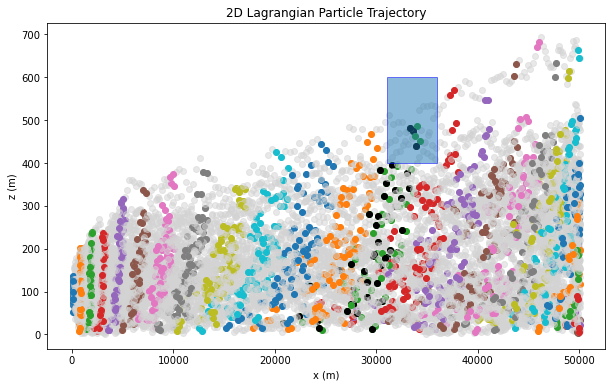

In [43]:
the_count = 0
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("2D Lagrangian Particle Trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
for j in range(50):
    x, y = do_LPT()
    ax.scatter(x, y, color="lightgrey", alpha=alpha)
    for i in range(len(x)):  
        if i % 10 == 0:
            ax.scatter([x[i], x[i+1]], [y[i], y[i+1]])
        if i == 120:
            ax.scatter(x[i], y[i], color="k")
            # count the particles inside the box
            if (31000 < x[i] < 36000) & (400 < y[i] < 600):
                the_count += 1

# show the box in which i am counting
rect = plt.Rectangle((31000,400), 5000, 200,fc=None, ec="blue", alpha=0.5)
plt.gca().add_patch(rect);

3) By hand, on your graph from C(2), pick a fixed domain (i.e., draw a rectange by hand) that
is 5 km wide and 200 m tall, with the base of the rectangle at z = 400 m.  Position this rectangle
in x such that it encloses the max number of black points with the fixed height range .
Count the number of black particles in this domain.


In [36]:
the_count # 0

0

4) Re-run C(2), which should give slightly different results because of the random numbers used
for the vertical dispersion.  For the exact same rectangle location as in C(3), count the number
of black points.

In [38]:
# run the simulation again but dont execute the cell above
the_count # 6

6

5) Repeat (re-run C(3)) three more times, and count the number of black points for each rerun. 
At this point, you should have a total of 5 separate counts of black particles in that one location.

In [40]:
the_count # 2

2

In [42]:
the_count # 3

3

In [44]:
the_count # 3

3

## D) Synthesis and Discussion

1) Can each count of black points represent instantaneous concentrations of pollutants?
If so, what is needed to enable that representation?

>*Yes, but they need to be divided by the area (volume in the "real" case) enclosed within the square. So the average concentation I calculated here is (0 + 6 + 2 + 3 + 3) / 6 dots / (5000m x200m) = 2.8 dots / km^2*

2) For the repeated realizations from part (C), do they represent an ensemble, or is each
realization similar to a subsequent time for the case where each run represents a different
emission time (as from a continuous emission from a point source). 

>*Yes, they do represent an ensemble, as the only parameter varying between simulations is the random numbers simulating turbulent transport. They could also represent the same emission occuring at different times, although they would have to be times > 1 lagrangian timescale apart, otherwise we would expect some autocorrelation between the turbulent fields (our simulation uses random fields, so there is no correlation at all)*

3) Based on your particle counts in the rectangle for each realization, what is needed to
enable those counts to represent an average concentration.  (Recall that air-quality
standards are based on average concentrations.)

>*Each run represents an instantaneous concentration, so we need to average over a number of runs. We shold also pay attention to what time-interval is specified over which to average, and that the model has sufficient resolution to capture short duration events if these are relevant*